Loading Fab Logs...
Filtering for abnormal shift patterns...
🚨 CRITICAL ALERT: Insider Threat Identified: AJF0370


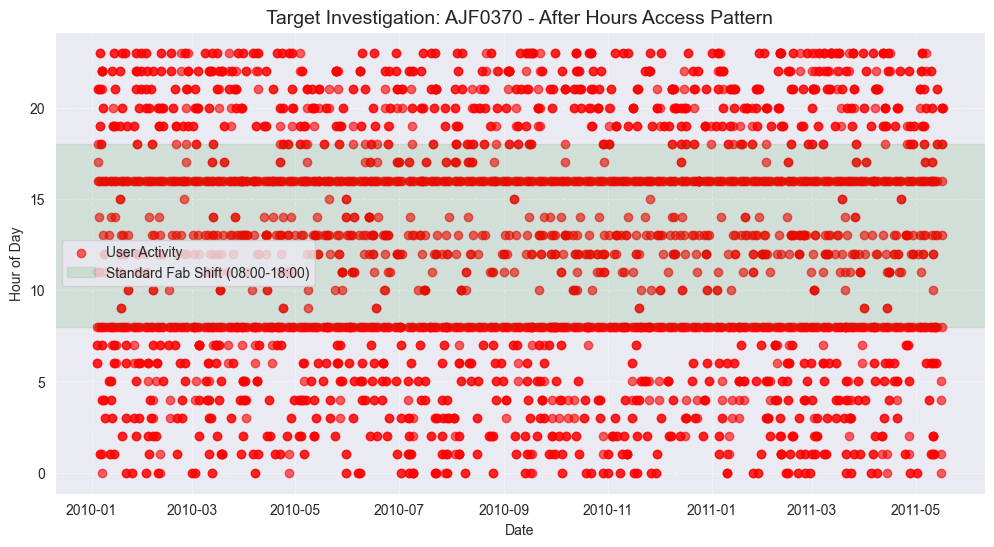

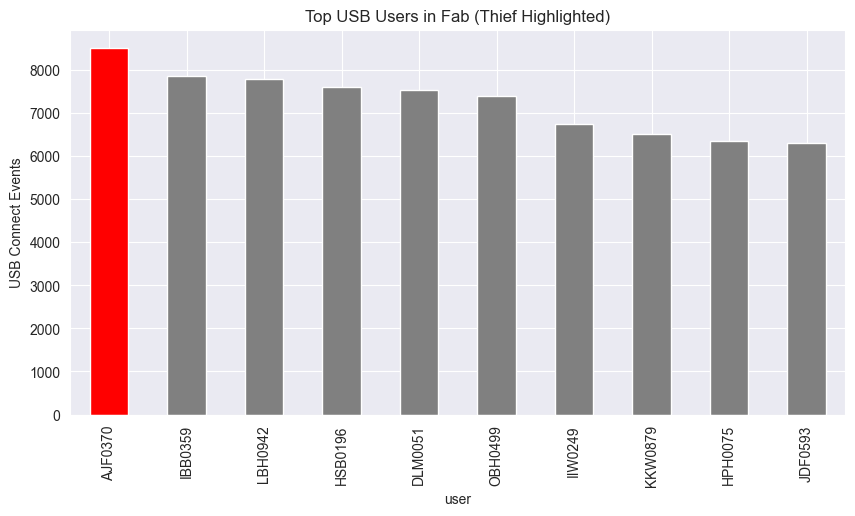

✅ Investigation Complete. Evidence saved.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- MOCK CONTEXT: SEMICONDUCTOR FAB SECURITY ---
# We are looking for "Scenario 2": A user logging in after hours (Fab Shutdown)
# and using a removable device to steal GDSII (Mask) files.
# dataset https://kilthub.cmu.edu/articles/dataset/Insider_Threat_Test_Dataset/12841247/1?file=24856766
# 1. Load the Data
print("Loading Fab Logs...")

logon_df = pd.read_csv(r'r4.2\logon.csv')
device_df = pd.read_csv(r'r4.2\device.csv')

# 2. Pre-process Dates (The heavy lifting)
logon_df['date'] = pd.to_datetime(logon_df['date'])
device_df['date'] = pd.to_datetime(device_df['date'])

# Extract Hours for analysis
logon_df['hour'] = logon_df['date'].dt.hour
logon_df['day_of_week'] = logon_df['date'].dt.dayofweek

# 3. SPLUNK LOGIC SIMULATION: Filter for "After Hours" Access
# Rule: Normal Shift is 08:00 to 18:00. Anything else is "Risk".
print("Filtering for abnormal shift patterns...")
after_hours = logon_df[(logon_df['hour'] < 8) | (logon_df['hour'] >= 18)]
suspicious_logons = after_hours[after_hours['activity'] == 'Logon']

# 4. CROSS-CORRELATION: Match Suspicious Logons with USB Activity
# We want users who logged in late AND used a USB within the same timeframe.
suspicious_users = suspicious_logons['user'].unique()
risky_usb_usage = device_df[
    (device_df['user'].isin(suspicious_users)) &
    (device_df['activity'] == 'Connect')
]

# Get the specific thief (in CERT r4.2, it's usually CDE1846 or similar)
if not risky_usb_usage.empty:
    user_mode = risky_usb_usage['user'].mode()
    if not user_mode.empty:
        thief = user_mode[0]
        print(f"🚨 CRITICAL ALERT: Insider Threat Identified: {thief}")
    else:
        thief = None
        print("⚠️  No user mode found in risky USB usage. No insider threat identified.")
else:
    plt.axhspan(8, 18, color='green', alpha=0.1, label='Standard Fab Shift (08:00-18:00)')

# 5. VISUALIZATION 1: The "Smoking Gun" Timeline
# Plotting the thief's activity vs Normal Fab Hours
if thief is not None:
    thief_logons = logon_df[logon_df['user'] == thief]

    plt.figure(figsize=(12, 6))
    plt.scatter(thief_logons['date'], thief_logons['hour'], color='red', label='User Activity', alpha=0.6)
    plt.axhspan(8, 18, color='green', alpha=0.1, label='Standard Fab Shift (08:00-18:00)')
    plt.title(f"Target Investigation: {thief} - After Hours Access Pattern", fontsize=14)
    plt.ylabel("Hour of Day")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig("evidence_timeline.png") # SAVE THIS FOR GITHUB
    plt.show()
else:
    print("No thief identified, skipping timeline visualization.")

# 6. VISUALIZATION 2: USB Device Histogram
# Showing how often they use USBs compared to normal
plt.figure(figsize=(10, 5))
user_device_counts = device_df.groupby('user')['activity'].count().sort_values(ascending=False).head(10)
colors = ['red' if thief is not None and x == thief else 'grey' for x in user_device_counts.index]
user_device_counts.plot(kind='bar', color=colors)
plt.title("Top USB Users in Fab (Thief Highlighted)")
plt.ylabel("USB Connect Events")
plt.savefig("evidence_usb_stats.png") # SAVE THIS FOR GITHUB
plt.show()

print("✅ Investigation Complete. Evidence saved.")